In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String
from sqlalchemy.orm import sessionmaker, declarative_base
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 1. `sqlalchemy` Database setup


In [ ]:
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")
DATABASE_URL

In [ ]:
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(bind=engine)
Base = declarative_base()

In [3]:
class Movie(Base):
    __tablename__ = "movies"
    movieId = Column(Integer, primary_key=True)
    title = Column(String)
    genres = Column(String)
    year = Column(Integer)
    tag = Column(String)
    keywords = Column(String)

In [4]:
db = SessionLocal()

# 2. Fetching data from `postgres`


In [5]:
movies = db.query(Movie).order_by(Movie.movieId).all()
len(movies)

9742

In [6]:
type(movies[0])

__main__.Movie

In [6]:
movies[:10]

In [7]:
[(movie.movieId, movie.title, movie.year) for movie in movies][:10]

[(0, 'Toy Story', 1995),
 (1, 'Jumanji', 1995),
 (2, 'Grumpier Old Men', 1995),
 (3, 'Waiting to Exhale', 1995),
 (4, 'Father of the Bride Part II', 1995),
 (5, 'Heat', 1995),
 (6, 'Sabrina', 1995),
 (7, 'Tom and Huck', 1995),
 (8, 'Sudden Death', 1995),
 (9, 'GoldenEye', 1995)]

In [8]:
keywords = [movie.keywords for movie in movies]
len(keywords)

9742

In [9]:
keywords[:10]

['adventure animation children comedy fantasy pixar fun',
 'adventure children fantasy magicboardgame robinwilliams game',
 'comedy romance moldy old',
 'comedy drama romance',
 'comedy pregnancy remake',
 'action crime thriller',
 'comedy romance remake',
 'adventure children',
 'action',
 'action adventure thriller']

# 3. TF-IDF recommender system


In [10]:
tf_idf_primer = TfidfVectorizer()
sparse_matrix_primer = tf_idf_primer.fit_transform(["action crime thriller", "war action drama", "love romance storytelling drama"])
sparse_matrix_primer

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10 stored elements and shape (3, 8)>

In [11]:
print("TF-IDF feature names:")
print(tf_idf_primer.get_feature_names_out())
print("\nSparse matrix TF-IDF scores:")
print(sparse_matrix_primer.toarray())

TF-IDF feature names:
['action' 'crime' 'drama' 'love' 'romance' 'storytelling' 'thriller' 'war']

Sparse matrix TF-IDF scores:
[[0.4736296  0.62276601 0.         0.         0.         0.
  0.62276601 0.        ]
 [0.51785612 0.         0.51785612 0.         0.         0.
  0.         0.68091856]
 [0.         0.         0.40204024 0.52863461 0.52863461 0.52863461
  0.         0.        ]]


In [12]:
tf_idf = TfidfVectorizer()
sparse_matrix = tf_idf.fit_transform(keywords)
sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 26769 stored elements and shape (9742, 1510)>

In [13]:
sparse_matrix.shape

(9742, 1510)

In [14]:
print("TF-IDF feature names:")
print(tf_idf.get_feature_names_out())
print("\nSparse matrix TF-IDF scores:")
print(sparse_matrix.toarray())

TF-IDF feature names:
['06oscarnominatedbestmovie' '1900s' '1920s' ... 'zoekazan' 'zombies'
 'zooeydeschanel']

Sparse matrix TF-IDF scores:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 3.1 Fetching the corresponding **movieId**


In [18]:
title = "Toy Story"
movie_id = db.query(Movie.movieId).filter(Movie.title == title).first()
movie_id, type(movie_id)

((0,), sqlalchemy.engine.row.Row)

In [19]:
title = "Toy Story"
movie_id = db.query(Movie.movieId).filter(Movie.title == title).scalar()
movie_id, type(movie_id)

(0, int)

## 3.2 Querying


In [20]:
query = sparse_matrix[movie_id]
query

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 1510)>

In [21]:
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [22]:
query.toarray().shape

(1, 1510)

## 3.3 Getting a result


In [23]:
scores = cosine_similarity(query, sparse_matrix)
scores

array([[1.        , 0.14663526, 0.01959694, ..., 0.        , 0.21884794,
        0.13902991]])

In [24]:
scores.shape

(1, 9742)

In [25]:
scores = scores.flatten()
scores.shape

(9742,)

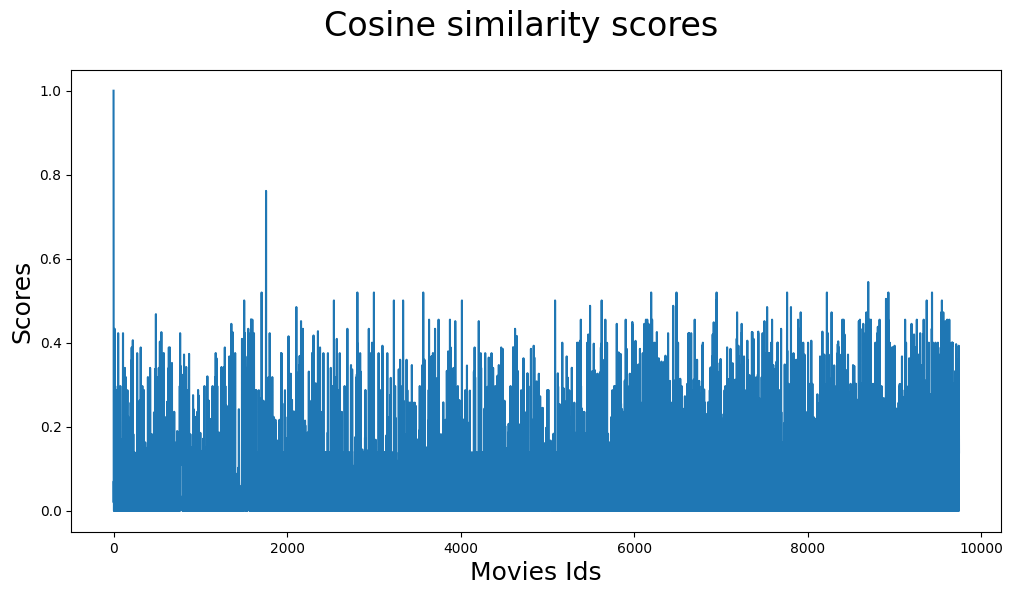

In [26]:
plt.figure(figsize=(12, 6))
plt.suptitle("Cosine similarity scores", fontsize=24)

plt.xlabel("Movies Ids", fontsize=18)
plt.ylabel("Scores", fontsize=18)

plt.plot(scores);

In [27]:
ordered_score = scores.argsort()
ordered_score

array([4870, 3517, 6316, ..., 8695, 1757,    0], dtype=int64)

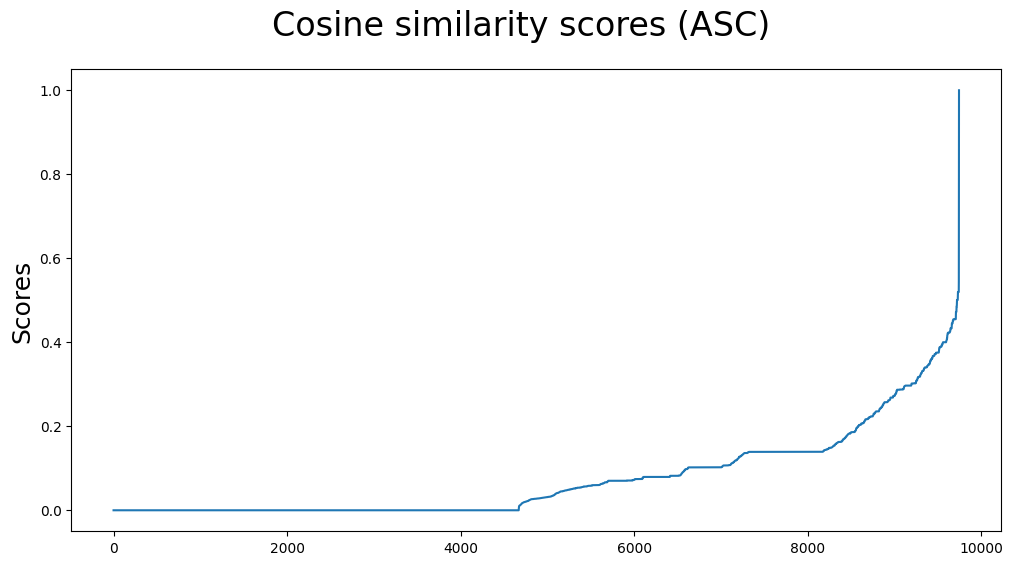

In [28]:
plt.figure(figsize=(12, 6))
plt.suptitle("Cosine similarity scores (ASC)", fontsize=24)

plt.ylabel("Scores", fontsize=18)

plt.plot(scores[ordered_score]);

In [29]:
ordered_score = (-scores).argsort()
ordered_score

array([   0, 1757, 8695, ..., 5327, 5325, 4870], dtype=int64)

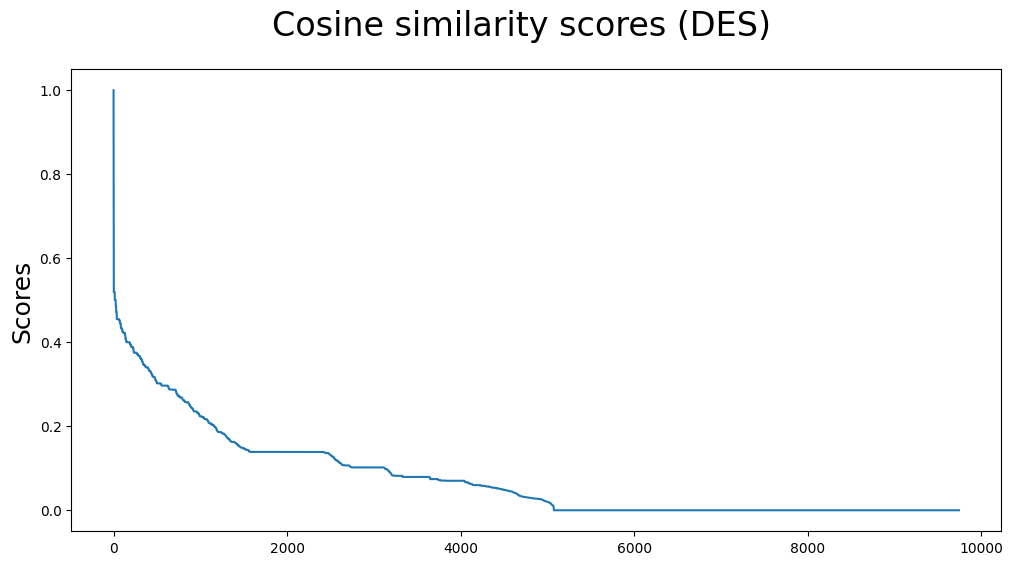

In [30]:
plt.figure(figsize=(12, 6))
plt.suptitle("Cosine similarity scores (DES)", fontsize=24)

plt.ylabel("Scores", fontsize=18)

plt.plot(scores[ordered_score]);

In [31]:
scores[ordered_score[:3]]

array([1.        , 0.76146368, 0.54461993])

In [32]:
recommended_movies_idx = ordered_score[1:6]
recommended_movies_idx

array([1757, 8695, 2809, 3000, 6948], dtype=int64)

In [33]:
type(recommended_movies_idx)

numpy.ndarray

In [34]:
recommended_movies_idx = recommended_movies_idx.tolist()
recommended_movies_idx

[1757, 8695, 2809, 3000, 6948]

In [35]:
recommended_movies = db.query(Movie).filter(Movie.movieId.in_(recommended_movies_idx)).all()
recommended_movies

In [36]:
[rec_movie.title for rec_movie in recommended_movies]

["Bug's Life, A",
 'Adventures of Rocky and Bullwinkle, The',
 "Emperor's New Groove, The",
 'Tale of Despereaux, The',
 'Guardians of the Galaxy 2']

# 4. Putting it together


In [37]:
all_titles = [title for title in db.query(Movie.title).order_by(Movie.movieId).all()]
all_titles = [t[0] for t in all_titles]

def tf_idf_recommender(title, k):
    movie_id = db.query(Movie.movieId).filter(Movie.title == title).scalar()
    query = sparse_matrix[movie_id]
    scores = cosine_similarity(query, sparse_matrix).flatten()

    ordered_score_idx = (-scores).argsort()
    recommended_movies_idx = ordered_score_idx[1:k+1].tolist()
    
    recommended_movies = [all_titles[m_id] for m_id in recommended_movies_idx]
    
    return recommended_movies

In [38]:
tf_idf_recommender("Braveheart", 5)

['Kill Bill: Vol. 2',
 'Mean Creek',
 'The Imitation Game',
 'Unforgiven',
 'Good Will Hunting']

In [39]:
braveheart = db.query(Movie).filter(Movie.title == "Braveheart").first()
braveheart.keywords

'action drama war beautifulscenery epic historical inspirational medieval melgibson oscar(bestcinematography) revenge swordfight scotland'

In [40]:
kill_bill_2 = db.query(Movie).filter(Movie.title == "Kill Bill: Vol. 2").first()
kill_bill_2.keywords

'action drama thriller revenge'

In [41]:
mean_creek = db.query(Movie).filter(Movie.title == "Mean Creek").first()
mean_creek.keywords

'drama thriller revenge'

In [42]:
imit_game = db.query(Movie).filter(Movie.title == "The Imitation Game").first()
imit_game.keywords

'drama thriller war inspirational intelligent'

In [7]:
db.close()